In [1]:
import os
import pickle
import numpy as np
from glob import glob
from pathlib import Path

from src.visualization.render_mp4 import create_mp4

import matplotlib.pyplot as plt

import zarr

In [2]:
demos_paths = list(Path("/data/scratch/ankile/teleop/lamp_demos").rglob("*.pkl"))

demos_paths

[]

## Look at a lot of lamp demos

### Inspect the videos themselves

In [3]:
dataset = zarr.open(
    "/data/scratch/ankile/furniture-data/data/processed/sim/image/lamp/data_batch_32.zarr",
    "r",
)

PathNotFoundError: nothing found at path ''

In [ ]:
# Get a numpy array representing the first 8 demos of image 2
idxs = dataset["episode_ends"][:20]

idxs

array([  678,  1220,  1852,  2495,  3156,  3815,  4534,  5277,  6118,
        6835,  7505,  8328,  8977,  9749, 10645, 11370, 12043, 12765,
       13434, 14087], dtype=uint32)

In [ ]:
arrays = []

prev_idx = 0
for idx in idxs:
    arrays.append(dataset["color_image2"][prev_idx:idx])
    prev_idx = idx

len(arrays)

20

In [ ]:
# Find the longest demo and pad the rest
max_len = max([len(a) for a in arrays])

for i in range(len(arrays)):
    arrays[i] = np.concatenate(
        (arrays[i], np.zeros((max_len - len(arrays[i]), 224, 224, 3), dtype=np.uint8))
    )

print([a.shape for a in arrays])

[(896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3), (896, 224, 224, 3)]


In [ ]:
# Concatenate the arrays in a 2 by 4 grid
rows = [np.concatenate(arrays[i : i + 20 // 4], axis=2) for i in range(0, 20, 20 // 4)]

# Concatenate the rows
grid = np.concatenate(rows, axis=1)

In [ ]:
# make a video
create_mp4(grid, "lamp_20.mp4", fps=10)

100%|██████████| 896/896 [00:05<00:00, 177.29it/s]


File saved as lamp_20.mp4


### Look at the actions and change in proprioceptive state

In [ ]:
end_idx = idxs[0]

actions = dataset["action"][:end_idx]
robot_states = dataset["robot_state"][:end_idx]

actions.shape, robot_states.shape

((678, 8), (678, 14))

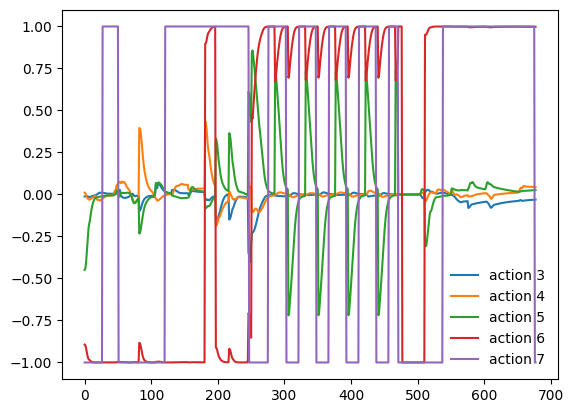

In [ ]:
# plot the actions over time
for i in range(3, 8):
    plt.plot(actions[:, i], label=f"action {i}")

plt.legend(frameon=False)

# plt.xlim(25, 45)

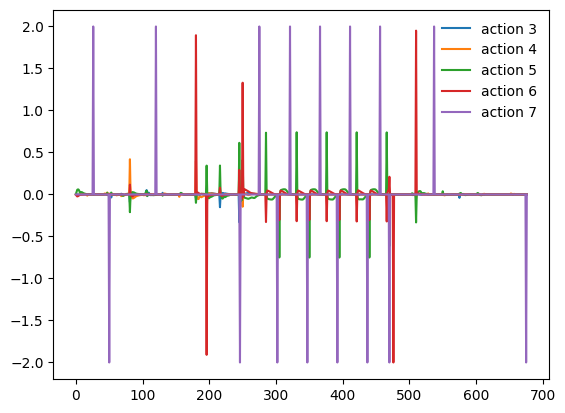

In [ ]:
# plot the change in actions over time
for i in range(3, 8):
    plt.plot(np.diff(actions[:, i]), label=f"action {i}")

plt.legend(frameon=False)

# plt.xlim(25, 45)

(25.0, 45.0)

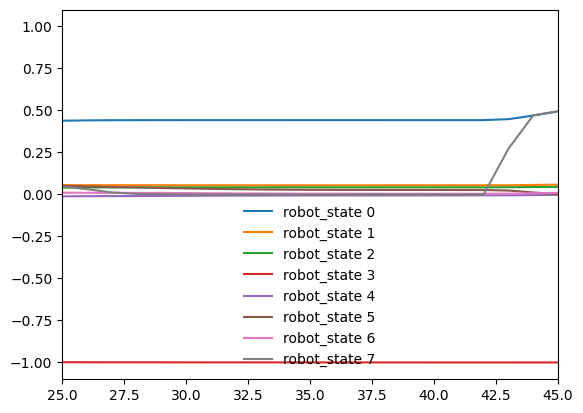

In [ ]:
# Plot the robot state of the robot over time
for i in range(8):
    plt.plot(robot_states[:, i], label=f"robot_state {i}")

plt.legend(frameon=False)

plt.xlim(25, 45)

(15.0, 50.0)

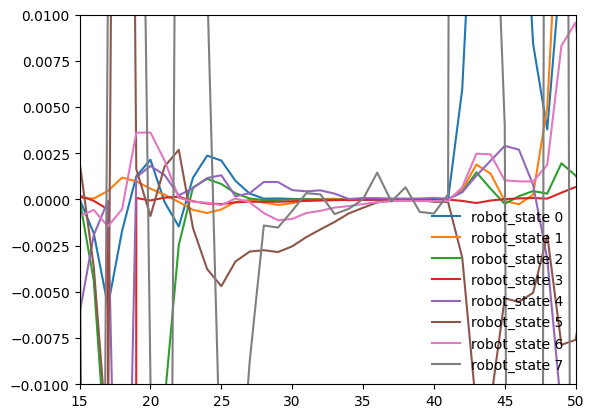

In [ ]:
# Plot the change in robot state of the robot over time
for i in range(8):
    plt.plot(np.diff(robot_states[:, i]), label=f"robot_state {i}")

plt.legend(frameon=False)

plt.ylim(-0.01, 0.01)
plt.xlim(15, 50)

In [ ]:
# Take out all timesteps where the robot is not moving
# Good to know that my quaternion is (x, y, z, w) and not (w, x, y, z)
not_moving = np.linalg.norm(actions[:, :6], axis=1) <= 0.01

not_moving.sum()

44

In [ ]:
np.where(not_moving)

(array([ 36,  37,  38,  39,  40,  41, 283, 284, 285, 331, 374, 375, 376,
        418, 419, 420, 421, 462, 463, 464, 465, 466, 471, 485, 486, 487,
        488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500,
        501, 502, 548, 549, 550]),)

## Remove no-op time steps and visualize the demos

In [ ]:
# Get a numpy array representing the first 8 demos of image 2
idxs = dataset["episode_ends"][:10]

image_arrays = []
actions_arrays = []

prev_idx = 0
for idx in idxs:
    image_arrays.append(dataset["color_image2"][prev_idx:idx])
    actions_arrays.append(dataset["action"][prev_idx:idx])
    prev_idx = idx

len(image_arrays)

10

In [ ]:
# Remove the timesteps where the robot is not moving
for i in range(len(image_arrays)):
    moving = np.linalg.norm(actions_arrays[i][:, :6], axis=1) > 0.025
    image_arrays[i] = image_arrays[i][moving]

In [ ]:
# Find the longest demo and pad the rest
max_len = max([len(a) for a in image_arrays])

for i in range(len(image_arrays)):
    image_arrays[i] = np.concatenate(
        (
            image_arrays[i],
            np.zeros((max_len - len(image_arrays[i]), 224, 224, 3), dtype=np.uint8),
        )
    )

print([a.shape for a in image_arrays])
# Concatenate the image_arrays in a 2 by 5 grid
rows = [
    np.concatenate(image_arrays[i : i + 10 // 2], axis=2) for i in range(0, 10, 10 // 2)
]

# Concatenate the rows
grid = np.concatenate(rows, axis=1)
# make a video
create_mp4(grid, "lamp_10_no_noop.mp4", fps=10)

[(703, 224, 224, 3), (703, 224, 224, 3), (703, 224, 224, 3), (703, 224, 224, 3), (703, 224, 224, 3), (703, 224, 224, 3), (703, 224, 224, 3), (703, 224, 224, 3), (703, 224, 224, 3), (703, 224, 224, 3)]


100%|██████████| 703/703 [00:02<00:00, 343.69it/s]


File saved as lamp_10_no_noop.mp4


## Look at new rollouts after revamp of the controller

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from pathlib import Path
import numpy as np
import cv2
import random

from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    create_mp4_jupyter,
    unpickle_data,
    data_to_video,
)

In [60]:
pkl_folder = (
    Path(os.environ["DATA_DIR_RAW"]) / "raw" / "sim" / "one_leg" / "scripted" / "low"
)
ts = ""


pkls = list(pkl_folder.rglob(f"*{ts}.pkl*"))
random.shuffle(pkls)

tmp = Path("/data/scratch/ankile/tmp")
tmp.mkdir(exist_ok=True)

print(f"Found {len(pkls)} pkls")

datas = []

# Make video of all the pkls
for i, pkl in enumerate(pkls[:1]):
    data = unpickle_data(pkl)
    print(
        data["observations"][0]["color_image1"].shape,
        data["observations"][0]["color_image2"].shape,
    )
    create_mp4_jupyter(data_to_video(data), tmp / f"tmp_{pkl.stem}.mp4", fps=60)

    datas.append(data)

Found 69 pkls
(240, 320, 3) (240, 320, 3)
File saved as /data/scratch/ankile/tmp/tmp_2024-01-20-16:46:18.pkl.mp4


In [59]:
datas[0]["observations"][0]["parts_poses"].shape

(35,)

In [46]:
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from src.data_processing.utils import resize, resize_crop
import torch

torch.Size([1, 720, 1280, 3]) torch.Size([1, 720, 1280, 3])
torch.Size([1, 3, 720, 1280]) 720 1280
torch.Size([1, 3, 240, 426])
53
torch.Size([1, 3, 240, 320])
torch.Size([1, 240, 320, 3])
(240, 320, 3) (240, 320, 3)


((240, 320, 3), (240, 320, 3))

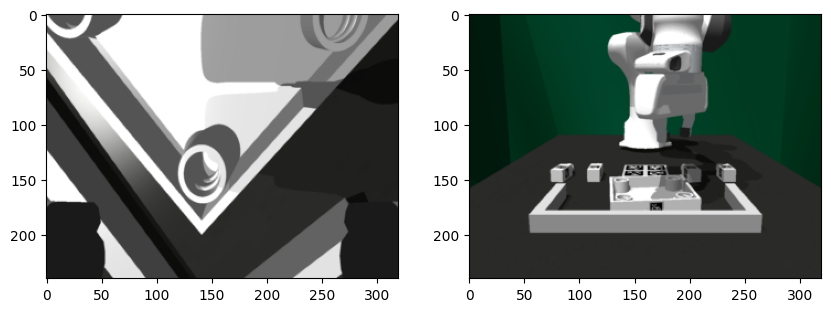

In [54]:
img1 = datas[0]["observations"][0]["color_image1"]
img2 = datas[0]["observations"][0]["color_image2"]

img1 = torch.from_numpy(img1)[None, ...]
img2 = torch.from_numpy(img2)[None, ...]

print(img1.shape, img2.shape)

img1 = resize(img1).squeeze().numpy()
img2 = resize_crop(img2).squeeze().numpy()

print(img1.shape, img2.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img1)
ax2.imshow(img2)

img1.shape, img2.shape

In [62]:
# Compare images 1 to each other and images 2 to each other
imgs11 = np.array([o["color_image1"] for o in datas[0]["observations"]])
imgs12 = np.array([o["color_image1"] for o in datas[1]["observations"]])
imgs13 = np.array([o["color_image1"] for o in datas[2]["observations"]])
imgs14 = np.array([o["color_image1"] for o in datas[3]["observations"]])


# Slice the videos to be the same length
minlen = min(len(imgs11), len(imgs12), len(imgs13), len(imgs14))
imgs11 = imgs11[:minlen]
imgs12 = imgs12[:minlen]
imgs13 = imgs13[:minlen]
imgs14 = imgs14[:minlen]

# Add text to each of the videos
for i in range(len(imgs11)):
    cv2.putText(
        imgs11[i],
        f"224 sim -> 224 resize",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    cv2.putText(
        imgs12[i],
        f"640 sim -> 224 resize",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    cv2.putText(
        imgs13[i],
        f"320 sim -> 224 resize",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    cv2.putText(
        imgs14[i],
        f"1280 sim -> 224 resize",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )


imgs1 = np.concatenate([imgs11, imgs12, imgs13, imgs14], axis=2)

imgs21 = np.array([o["color_image2"] for o in datas[0]["observations"]])
imgs22 = np.array([o["color_image2"] for o in datas[1]["observations"]])
imgs23 = np.array([o["color_image2"] for o in datas[2]["observations"]])
imgs24 = np.array([o["color_image2"] for o in datas[3]["observations"]])

# Slice the videos to be the same length
minlen = min(len(imgs21), len(imgs22), len(imgs23), len(imgs24))
imgs21 = imgs21[:minlen]
imgs22 = imgs22[:minlen]
imgs23 = imgs23[:minlen]
imgs24 = imgs24[:minlen]

imgs2 = np.concatenate([imgs21, imgs22, imgs23, imgs24], axis=2)

# Concatenate the videos
grid = np.concatenate([imgs1, imgs2], axis=1)

grid.shape

(914, 448, 896, 3)

In [63]:
# make a video
create_mp4_jupyter(grid, tmp / "grid.mp4", fps=30)

File saved as /data/scratch/ankile/tmp/grid.mp4


In [31]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [35]:
# make an image with a square in the middle
img = np.zeros((720, 1280, 3), dtype=np.uint8)
img[200:520, 280:600] = 255

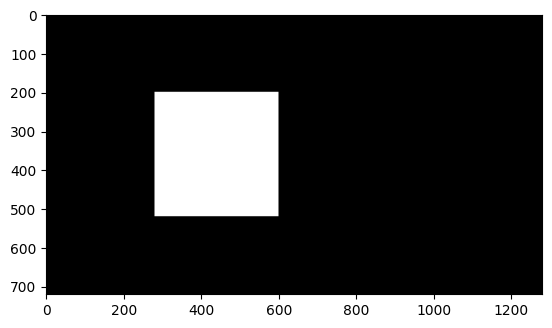

In [36]:
# Show the image
plt.imshow(img)

In [37]:
def resize_crop(img):
    """Resizes `img` and center crops into 320x240."""
    th, tw = 240, 320
    ch, cw = img.shape[:2]

    # Calculate the aspect ratio of the original image.
    aspect_ratio = cw / ch

    # Resize based on the width, keeping the aspect ratio constant.
    new_width = int(th * aspect_ratio)
    img = cv2.resize(img, (new_width, th), interpolation=cv2.INTER_AREA)

    # Calculate the crop size.
    crop_size = (new_width - tw) // 2

    # Crop the image.
    img = img[:, crop_size : new_width - crop_size]

    return img

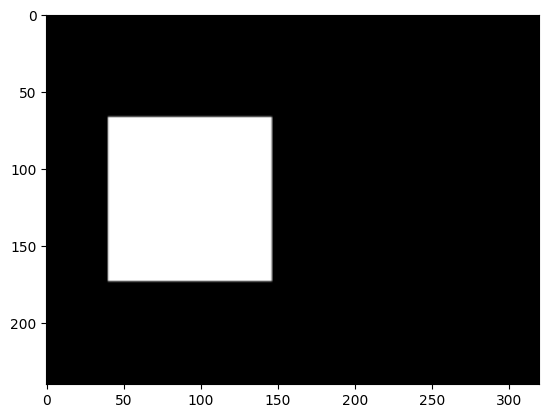

In [38]:
img = resize_crop(img)

plt.imshow(img)

In [39]:
pkl_folder = Path(os.environ["DATA_DIR_RAW"]) / "raw" / "real"
ts = ""
pkls = sorted(list(pkl_folder.rglob(f"*{ts}.pkl*")), reverse=False)

tmp = Path("/data/scratch/ankile/tmp")
tmp.mkdir(exist_ok=True)

print(f"Found {len(pkls)} pkls")

datas = []

# Make video of all the pkls
for i, pkl in enumerate(pkls):
    data = unpickle_data(pkl)
    print(
        data["observations"][0]["color_image1"].shape,
        data["observations"][0]["color_image2"].shape,
    )
    create_mp4_jupyter(data_to_video(data), tmp / f"tmp_{pkl.stem}.mp4", fps=30)

    datas.append(data)

Found 18 pkls
(224, 224, 3) (224, 224, 3)
File saved as /data/scratch/ankile/tmp/tmp_00000.mp4


(224, 224, 3) (224, 224, 3)
File saved as /data/scratch/ankile/tmp/tmp_00001.mp4


(224, 224, 3) (224, 224, 3)
File saved as /data/scratch/ankile/tmp/tmp_00002.mp4


(224, 224, 3) (224, 224, 3)
File saved as /data/scratch/ankile/tmp/tmp_00003.mp4


KeyboardInterrupt: 